# Neural networks

In [8]:
import gzip, pickle, time, torch, os, sys, pickle
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Pytorch를 활용한 Network 정의

### 간단한 Fully-connected neural network 정의

In [2]:
class FCNN(nn.Module):
    # 모델 정의
    def __init__(self, 
                 num_feat,
                 num_output,
                 num_node = 32,
                 num_layer = 4,
                 dropout_rate = 0,
                 batch_norm = False,
        ):
        # nn.Module 초기화
        super(FCNN, self).__init__()
        
        # embedding layer 정의
        self.embed = nn.Sequential(
            nn.Linear(num_feat, num_node), # Linear layer
            nn.ReLU(), # activation function
        )
        
        # hidden layer 정의
        self.hidden = nn.ModuleList()
        for _ in range(num_layer):
            hidden_layer = [] # List 형태로 만든 후 순차적으로 layer 요소 추가
            hidden_layer.append(nn.Linear(num_node, num_node)) 
            hidden_layer.append(nn.ReLU())

            # Layer normalization, gradient가 발산/수렴하는 것을 방지해서 훈련 효율을 높임
            # 둘 중 하나만 사용하면 됨
            if dropout_rate != 0: # Dropout 정의
                hidden_layer.append(nn.Dropout(dropout_rate))
            if batch_norm: # batch normalization 정의
                hidden_layer.append(nn.BatchNorm1d(num_node))
            self.hidden.append(nn.Sequential(*hidden_layer))

        self.output = nn.Sequential(
            nn.Linear(num_node, num_output),
        )
    
    # 순방향 함수 정의
    # input x가 들어와서 어떤 연산을 거쳐 output이 될 지 정의하는 함수
    def forward(self, x):
        # embedding layer 통과
        h = self.embed(x)
        # 각 layer를 순차적으로 통과
        for layer in self.hidden:
            h = layer(h)
        # output layer 통과
        out = self.output(h)
        return out

### Convolution neural network 정의

In [2]:
class CNN2D(nn.Module):
    # 모델 정의
    def __init__(self, 
                 in_dim,
                 in_channel,
                 num_output,
                 out_channel = 32,
                 kernel_size = 3,
                 stride = 1,
                 padding = 0,
                 dilation = 1,
                 num_layer = 3,
                 dropout_rate = 0,
                 batch_norm = False,
        ):
        # nn.Module 초기화
        super(CNN2D, self).__init__()

        self.embed = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding, dilation),
            nn.LeakyReLU(0.1)
        )
        # image size 계산
        n = int((in_dim + 2 * padding - dilation * (kernel_size - 1) - 1) / stride) + 1
#        print(n)

        # hidden layer 정의
        self.hidden = nn.ModuleList()
        for _ in range(num_layer):
            hidden_layer = [] # List 형태로 만든 후 순차적으로 layer 요소 추가
            hidden_layer.append(nn.Conv2d(out_channel, out_channel, kernel_size, stride, padding, dilation)) 
            hidden_layer.append(nn.LeakyReLU(0.1))

            # image size 계산
            n = (n + 2 * padding - dilation * (kernel_size - 1) - 1)
            if n < 0:
                raise ValueError('Kernel size can\'t be greater than actual input size', n)
            n = int(n / stride) + 1
#            print(n)
            # Layer normalization, gradient가 발산/수렴하는 것을 방지해서 훈련 효율을 높임
            # 둘 중 하나만 사용하면 됨
            if dropout_rate != 0: # Dropout 정의
                hidden_layer.append(nn.Dropout(dropout_rate))
            if batch_norm: # batch normalization 정의
                hidden_layer.append(nn.BatchNorm2d(out_channel))
            hidden_layer.append(nn.MaxPool2d(2))

            # image size 계산
            if n < 2:
                raise ValueError('Kernel size can\'t be greater than actual input size', n)
            n = int((n - 2)/ 2) + 1
#            print(n)

            self.hidden.append(nn.Sequential(*hidden_layer))

        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n * n * out_channel, num_output)
        )
    
    # 순방향 함수 정의
    # input x가 들어와서 어떤 연산을 거쳐 output이 될 지 정의하는 함수
    def forward(self, x):
        # embedding layer 통과
        h = self.embed(x)
#        print(h.shape)
        # 각 layer를 순차적으로 통과
        for layer in self.hidden:
            h = layer(h)
#            print(h.shape)
        # output layer 통과
        out = self.output(h)
#        print(out.shape)
        return out

### MNIST dataset

In [3]:
with gzip.open('../data/mnist.pkl.gzip','rb') as f:
    mnist = pickle.load(f)

x_mnist_train = mnist['train']['x']
y_mnist_train = mnist['train']['y']
x_mnist_test = mnist['test']['x']
y_mnist_test = mnist['test']['y']

x_train = torch.from_numpy(x_mnist_train).short() # 16-bit integer
print(x_train.shape)
x_train.to(device)
# long code ...

torch.Size([60000, 784])


tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.int16)

In [5]:
class MnistFlatData(Dataset):
    def __init__(self, x, y, device='cpu'):
        # Dataset 초기화
        super(MnistFlatData, self).__init__()
        # Input이 Tensor일 경우와 Tensor가 아닐 경우
        if isinstance(x, torch.Tensor):
            self._x = x.type(torch.float).to(device)
        else:
            self._x = torch.tensor(x, dtype=torch.float).to(device)
        
        # Label에 대해서도 동일한 작업 수행
        if isinstance(y, torch.Tensor):
            self._y = y.type(torch.long).to(device)
        else:
            self._y = torch.tensor(y, dtype=torch.long).to(device)

    def __len__(self):
        return self._x.shape[0]
    
    def __getitem__(self, i):
        return self._x[i], self._y[i]

- FCNN을 이용한 훈련

In [21]:

device = 'cpu'
epochs = 200

train_dataset = MnistFlatData(x_mnist_train, y_mnist_train, device=device)
test_dataset = MnistFlatData(x_mnist_test, y_mnist_test, device=device)

# 데이터 로더 정의
# 거대한 데이터를 배치로 나눠서 줌.
train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=1024)

# 모델 정의
model = FCNN(784, 10)
model.to(device)

# loss 함수 정의
# classification은 CrossEntropyLoss, 
# regression은 L1 또는 L2 loss
# 이 외에도 모델에 따라 다양한 형태의 loss 함수를 사용함.
# 모델이 연산하려는 특성에 맞는 수학적 모델을 사용해야 함.

crit = nn.CrossEntropyLoss()
# 최적화 알고리즘 정의
opt = torch.optim.SGD(model.parameters(), lr=1e-3)

# 훈련 시작
test_results = {}
loss_data = []
for epoch in range(epochs):
    # 훈련
    t1 = time.time()
    model.train()
    train_loss = 0
    
    # batch 에 대해 iteration
    for feat, target in train_dl:
        pred = model(feat) # 예측
        loss = crit(pred, target) # loss 계산
        
        opt.zero_grad() # gradient 초기화
        loss.backward() # loss 역전파
        opt.step()
        
        train_loss += loss.detach().item()
    train_loss = train_loss / len(train_dl)
    t2 = time.time()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        test_result = []
        for feat, target in test_dl:
            pred = model(feat)
            loss = crit(pred, target)
            
            test_loss += loss.detach().item()
            
            # 일정 epoch 마다 예측 결과 저장
            if (epoch + 1) % 50 == 0:
                test_result.append(pred)
    
    if len(test_result) != 0:
        test_results[epoch] = torch.concat(test_result, dim=0).cpu().numpy()
    test_loss = test_loss / len(test_dl)
    t3 = time.time()
    loss_data.append([train_loss, test_loss, t3 - t1])
    if (epoch + 1) % 10 == 0:
        print('{:5d}/{:5d} | {:13.8f} | {:13.8f} | {:6.2f} sec | {:6.2f} sec |'.format(epoch + 1, epochs, train_loss, test_loss, t2 - t1, t3 - t2))

with open('../output/_mnist_fcnn_cpu_b0064.pkl','wb') as f:
    pickle.dump([loss_data, test_results], f)


   10/  200 |    0.15824695 |    0.18053398 |   1.22 sec |   0.04 sec |
   20/  200 |    0.10939621 |    0.15424023 |   1.19 sec |   0.04 sec |
   30/  200 |    0.08430914 |    0.13950413 |   1.14 sec |   0.03 sec |
   40/  200 |    0.06789652 |    0.14525024 |   1.15 sec |   0.03 sec |
   50/  200 |    0.05505929 |    0.13687451 |   1.13 sec |   0.04 sec |
   60/  200 |    0.04446900 |    0.15920800 |   1.14 sec |   0.03 sec |
   70/  200 |    0.03633982 |    0.14936977 |   1.25 sec |   0.04 sec |
   80/  200 |    0.02976704 |    0.15584669 |   1.16 sec |   0.03 sec |
   90/  200 |    0.02426066 |    0.17133003 |   1.15 sec |   0.03 sec |
  100/  200 |    0.01935823 |    0.20278626 |   1.15 sec |   0.03 sec |
  110/  200 |    0.01537940 |    0.19663473 |   1.14 sec |   0.03 sec |
  120/  200 |    0.01113655 |    0.20860276 |   1.17 sec |   0.07 sec |
  130/  200 |    0.00854991 |    0.23983564 |   1.14 sec |   0.04 sec |
  140/  200 |    0.00737947 |    0.26643281 |   1.12 sec |   0.0

In [27]:
output = {}
for dev in ['cpu','cuda']:
    for b in [64, 256, 1024]:
        with open(f'../output/mnist_fcnn_{dev}_b{b:04d}.pkl','rb') as f:
            train_info, test_result = pickle.load(f)
        output[f'{dev}_{b:04d}'] = train_info, test_result        

(0.1, 0.25)

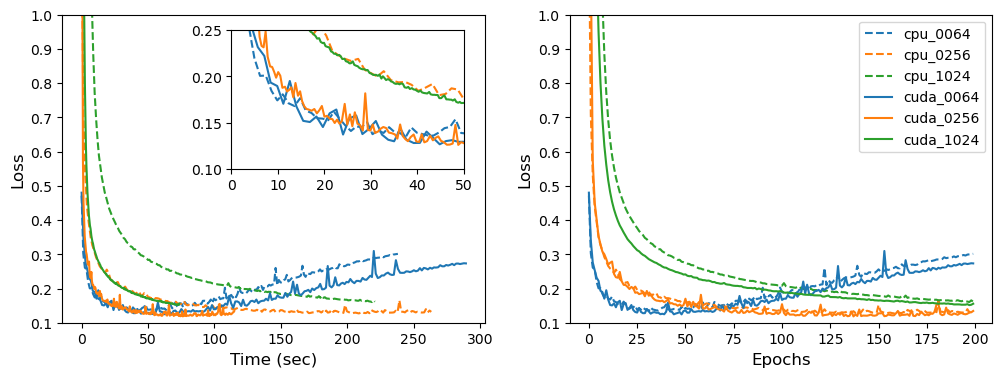

In [63]:
f, axs = plt.subplots(1,2,figsize=(12,4))
axin = axs[0].inset_axes([0.4, 0.5, 0.55, 0.45])
for k, (train_info, _) in output.items():
    tr_loss, te_loss, t = np.array(train_info).T
    x_time = [np.sum(t[:i]) for i in range(len(t))]
    x_epoch = np.arange(len(t))
    ls = '--' if 'cpu' in k else '-'
    j = 0
    if '0256' in k: j = 1
    if '1024' in k: j = 2
#    axs[0].plot(x_time, train_loss, color=mpl.cm.tab10(j))
    axs[0].plot(x_time, te_loss, ls=ls, color=mpl.cm.tab10(j), label=k)
    axin.plot(x_time, te_loss, ls=ls, color=mpl.cm.tab10(j))
#    axs[1].plot(x_epoch, train_loss, color=mpl.cm.tab10(j))
    axs[1].plot(x_epoch, te_loss, ls=ls, color=mpl.cm.tab10(j), label=k)
for ax in axs:
    ax.set_ylim([0.1, 1])
    ax.set_ylabel('Loss', fontsize=12)
axs[0].set_xlabel('Time (sec)', fontsize=12)
axs[1].set_xlabel('Epochs', fontsize=12)
axs[1].legend(loc='upper right')
axin.set_xlim([0, 50])
axin.set_ylim([0.1, 0.25])

batch size가 작을 때에는 CPU 머신이 더 빠르지만, batch가 커질수록 CUDA core의 병렬화 효율이 좋아져 GPU 머신의 속도가 빠름.

거대한 모델을 다룰수록 GPU가 필수적으로 요구됨.

- CNN을 이용한 훈련

각 기능들을 class로 만들어 효율적으로 코드 실행

In [4]:
class Trainer:
    def __init__(self, model, opt, crit):
        self._model = model
        self._opt = opt
        self._crit = crit

    def train(self, dataloader):
        self._model.train()
        train_loss = 0
        for feat, target in dataloader:
            pred = self._model(feat) # 예측
            loss = self._crit(pred, target) # loss 계산
            
            self._opt.zero_grad() # gradient 초기화
            loss.backward() # loss 역전파
            self._opt.step()
            
            train_loss += loss.detach().item()
        return train_loss / len(dataloader)
    
    def eval(self, dataloader):
        self._model.eval()
        eval_loss = 0
        eval_output = []
        with torch.no_grad():
            for feat, target in dataloader:
                pred = self._model(feat)
                loss = self._crit(pred, target)

                eval_loss += loss.detach().item()
                eval_output.append(pred)
        return eval_loss / len(dataloader), torch.concat(eval_output, dim=0).cpu().numpy()
    
    def pred(self, dataloader):
        self._model.eval()
        pred_output = []
        with torch.no_grad():
            for feat, _ in dataloader:
                pred = self._model(feat)
                pred_output.append(pred)
        return torch.concat(pred_output, dim=0).cpu().numpy()

class Mnist2DData(Dataset):
    def __init__(self, x, y, device='cpu'):
        # Dataset 초기화
        super(Mnist2DData, self).__init__()
        # Input이 Tensor일 경우와 Tensor가 아닐 경우
        if isinstance(x, torch.Tensor):
            self._x = x.type(torch.float).to(device)
        else:
            self._x = torch.tensor(x, dtype=torch.float).to(device)

        # 그림 형태로 변환
        self._x = self._x.view(-1, 1, 28, 28)

        # Label에 대해서도 동일한 작업 수행
        if isinstance(y, torch.Tensor):
            self._y = y.type(torch.long).to(device)
        else:
            self._y = torch.tensor(y, dtype=torch.long).to(device)

    def __len__(self):
        return self._x.shape[0]
    
    def __getitem__(self, i):
        return self._x[i], self._y[i]

In [11]:
def run_cnn(batch_size):
    epochs = 200

    device = 'cpu'
    train_dataset = Mnist2DData(x_mnist_train, y_mnist_train, device=device)
    test_dataset = Mnist2DData(x_mnist_test, y_mnist_test, device=device)

    # 데이터 로더 정의
    # 거대한 데이터를 배치로 나눠서 줌.
    train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test_dataset, batch_size=1024)

    # 모델 정의
    model = CNN2D(28, 1, 10, 32)
    model.to(device)

    crit = nn.CrossEntropyLoss()
    # 최적화 알고리즘 정의
    opt = torch.optim.SGD(model.parameters(), lr=1e-3)

    tr = Trainer(model, opt, crit)
    # 훈련 시작

    output_path = f'../output/mnist_cnn2d_{device}_b{batch_size:04d}'
    os.makedirs(output_path, exist_ok=True)
    writer = SummaryWriter(output_path)
    best_loss = 1e5
    for epoch in range(epochs):
        # 훈련
        t1 = time.time()
        train_loss = tr.train(train_dl)
        test_loss, test_result = tr.eval(test_dl)
        t3 = time.time()
        writer.add_scalar('Loss/Train', train_loss, epoch+1)
        writer.add_scalar('Loss/Test', test_loss, epoch+1)
        if (epoch + 1) % 50 == 0:
            with open(f'{output_path}/{epoch+1:04d}.pkl','wb') as f:
                pickle.dump(test_result, f)
        if test_loss < best_loss:
            best_loss = test_loss
            with open(f'{output_path}/best.pkl','wb') as f:
                pickle.dump(test_result, f)
            with open(f'{output_path}/log.txt','w') as f:
                f.write(f'{epoch+1:04d} {train_loss:15.8f} {test_loss:15.8f}')
        with open(f'{output_path}/loss.txt','a') as f:
            f.write('{:10.4f} {:15.8f} {:15.8f}\n'.format(t3-t1, train_loss, test_loss))

In [12]:
run_cnn(64)
run_cnn(256)
run_cnn(1024)

- Data scaling 효과

In [ ]:
class Mnist2DScaleData(Mnist2DData):
    def __init__(self, x, y, device='cpu'):
        # Dataset 초기화
        super(Mnist2DScaleData, self).__init__(x, y, device)
        self._x = self._x / 255.

In [19]:
m(x)

tensor([[ 0.0738,  0.0658,  0.1114,  0.1635,  0.0145, -0.0531, -0.1116, -0.1183,
          0.0943, -0.1936],
        [ 0.0685,  0.0705,  0.1130,  0.1661,  0.0134, -0.0569, -0.1087, -0.1230,
          0.0972, -0.1941],
        [ 0.0716,  0.0686,  0.1118,  0.1677,  0.0130, -0.0523, -0.1120, -0.1185,
          0.0954, -0.1924],
        [ 0.0754,  0.0665,  0.1141,  0.1651,  0.0143, -0.0513, -0.1102, -0.1221,
          0.0915, -0.1946],
        [ 0.0661,  0.0695,  0.1111,  0.1693,  0.0100, -0.0565, -0.1106, -0.1211,
          0.1020, -0.1937],
        [ 0.0726,  0.0649,  0.1116,  0.1682,  0.0135, -0.0517, -0.1106, -0.1160,
          0.0956, -0.1916],
        [ 0.0724,  0.0654,  0.1148,  0.1632,  0.0130, -0.0519, -0.1110, -0.1208,
          0.0964, -0.1906],
        [ 0.0681,  0.0675,  0.1095,  0.1682,  0.0138, -0.0534, -0.1136, -0.1216,
          0.0989, -0.1937],
        [ 0.0663,  0.0685,  0.1108,  0.1657,  0.0138, -0.0552, -0.1082, -0.1219,
          0.0963, -0.1933],
        [ 0.0713,  